# Simple 1010 Pattern

Make Your First GAN With PyTorch, 2020

In [4]:
# import libraries

import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

## Data Functions

In [5]:
# 真实数据源可以是一个一直返回1010格式规律的数据的函数

def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

generate_real()

tensor([0.9077, 0.0211, 0.9104, 0.1048])

In [6]:
# 生成随机数据

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

## Discriminator Network

In [7]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Test Discriminator

In [8]:
# test discriminator can separate real data from random noise

D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


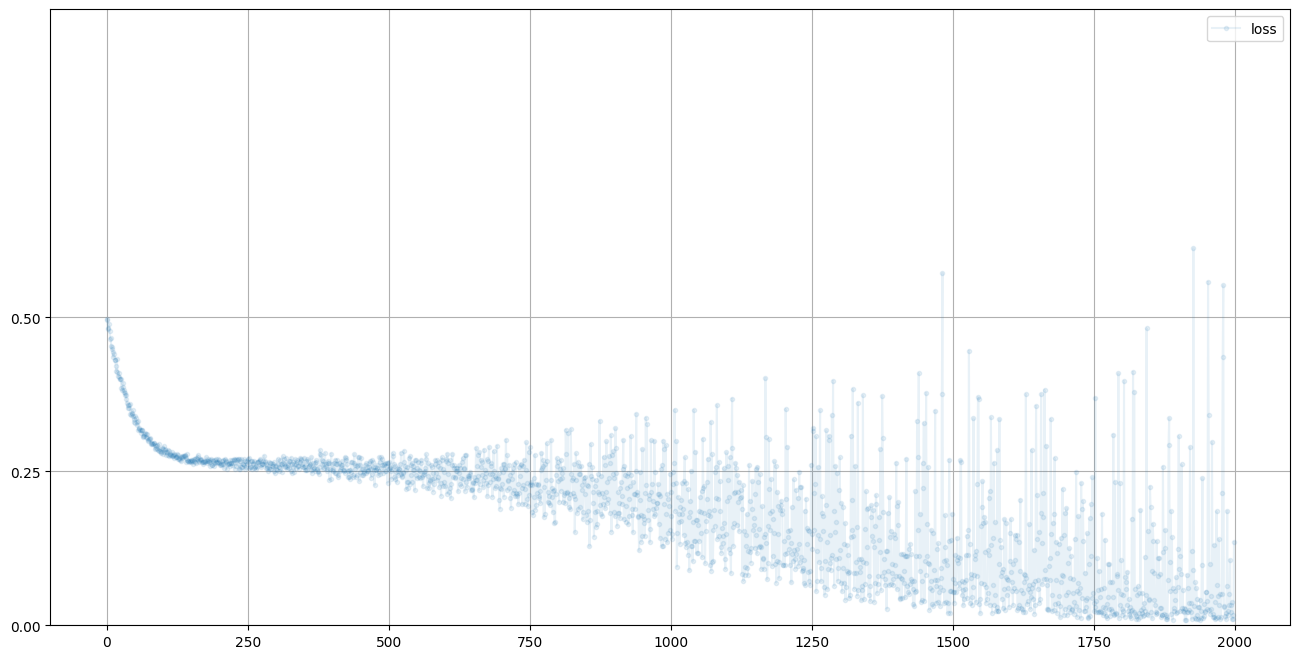

In [9]:
# plot discriminator loss

D.plot_progress()

In [10]:
# manually run discriminator to check it can tell real data from fake

print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7666029930114746
0.10701318830251694


## Generator Network
![生成器网络结构](image\06_gen_network.png)

In [11]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 这里没有使用self.loss_function，因为
        # 我们不需要它了。回顾GAN的训练循环，我们使用的唯一的损失函
        # 数是根据鉴别器的输出计算的。最后，我们根据由鉴别器损失值计
        # 算的误差梯度来更新生成器。

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)
        
        # 输入鉴别器
        d_output = D.forward(g_output)
        
        # 计算损失值
        loss = D.loss_function(d_output, targets)

        #  每训练10次增加计数器
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## Test Generator Output

In [12]:
# check the generator output is of the right type and shape

G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.5894, 0.5740, 0.5359, 0.5723], grad_fn=<SigmoidBackward0>)

## Train GAN

In [13]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # 使用detach()以避免计算生成器G中的梯度
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: total: 3.06 s
Wall time: 15.7 s


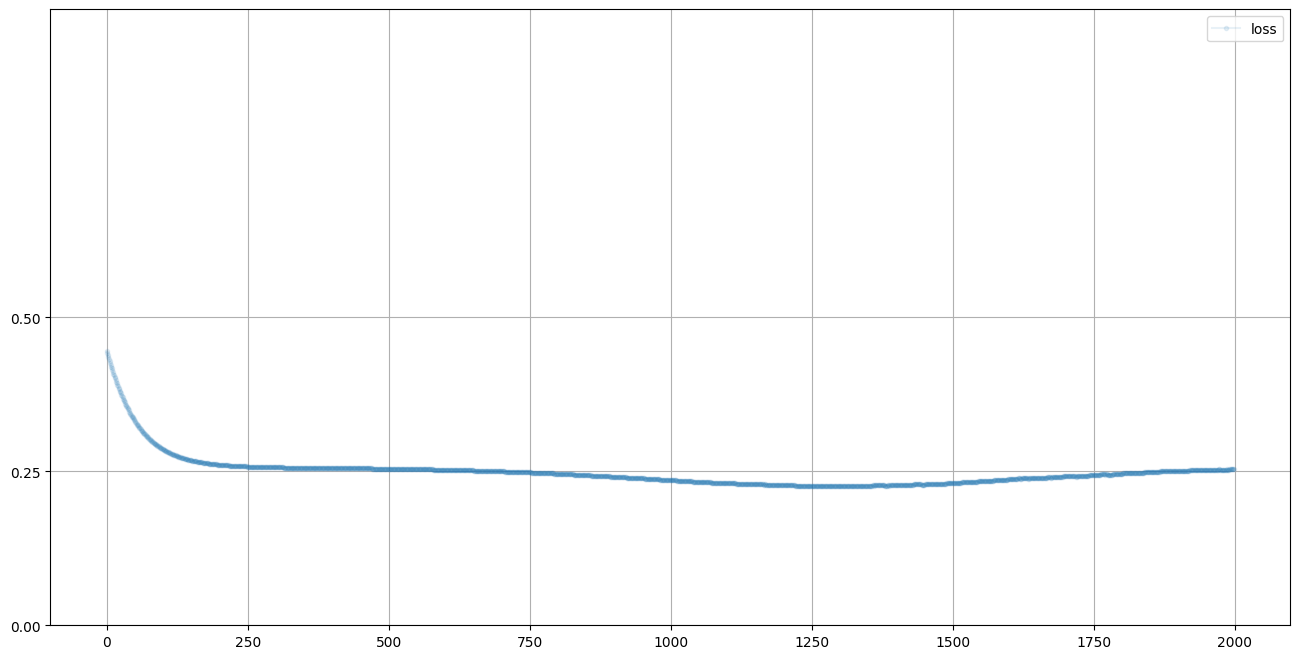

In [14]:
# plot discriminator error

D.plot_progress()

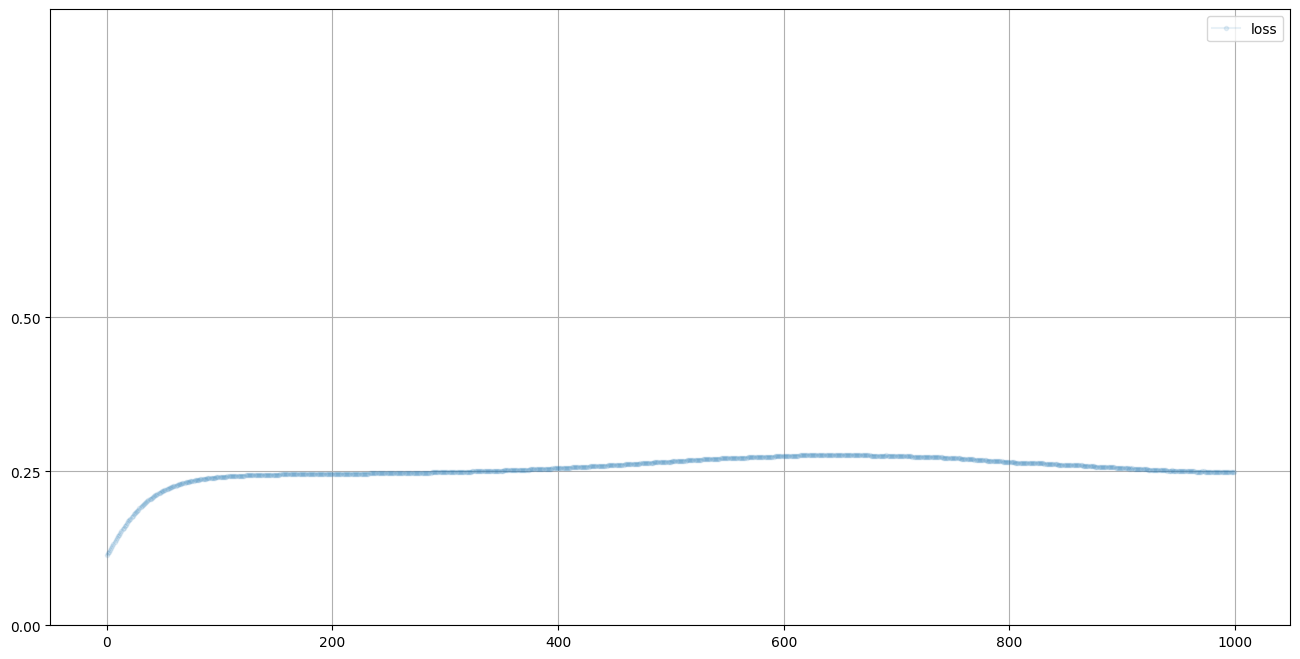

In [15]:
# plot generator error

G.plot_progress()

## Manually Run Generator

In [20]:
# manually run generator to see it's outputs

G.forward(torch.FloatTensor([0.5]))

tensor([0.9043, 0.0807, 0.8609, 0.0902], grad_fn=<SigmoidBackward0>)

## Visualise Pattern During Training

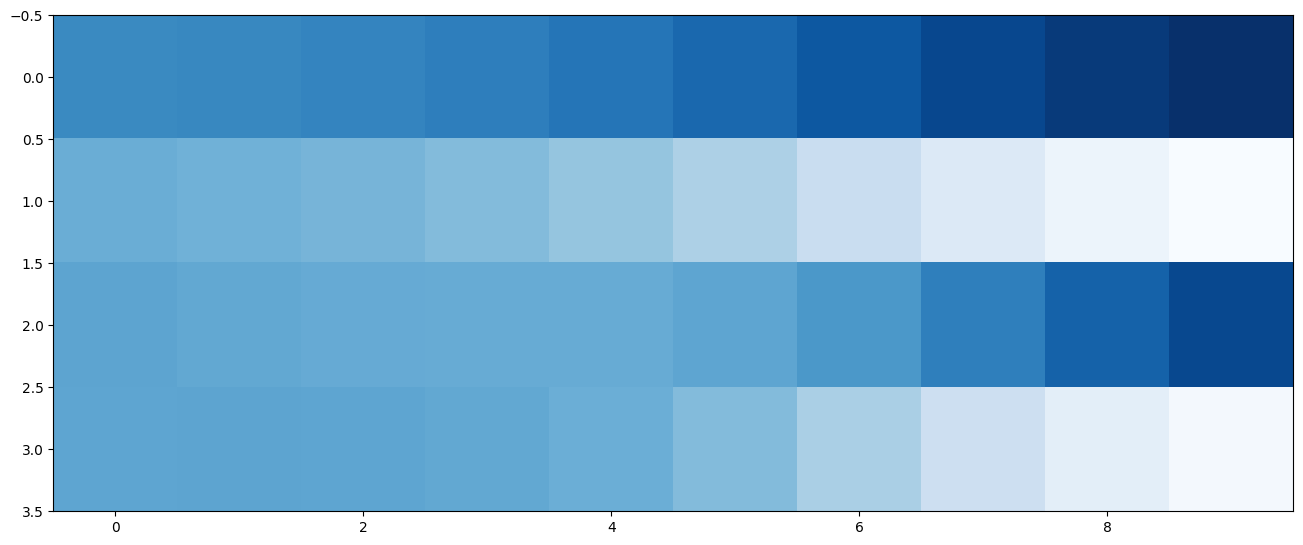

In [21]:
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')